# France optimized Case Study

In [4]:
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns

from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib
import plotly.express as px
import plotly.graph_objects as go


In [5]:
# Importing functions 
from import_excel import import_excel

from calc_translations import calculate_all_translations
from wavelet_decomposition import compute_wavelet_coefficient_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct
from plots import plot_betas_heatmap
from plots import plot_EPN
from calc_EPN import calc_epn
from plots import fft
from miscelaneous_functions import create_directory

In [6]:
country_name = 'France'

### Importing Time Series

In [8]:
# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpy
dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years


# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

#
# Directory path
path_input_data = 'input_time_series/'
file_name = f'{country_name}/test_wavelet_dispatchable.xlsx'

dispatch_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day

In [9]:

# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpy
dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years


# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

#
# Directory path
path_input_data = 'input_time_series/'

file_name = f'{country_name}/France_load_entsoe_2021.xlsx'
Load_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day

In [13]:

# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpy
dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years


# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

#
# Directory path
path_input_data = 'input_time_series/'

file_name = f'{country_name}/solar_generation_France_2019_opsd.xlsx'
PV_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day

In [31]:

# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpy
dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years


# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

#
# Directory path
path_input_data = 'input_time_series/'

file_name = f'{country_name}/wind_onshore_generation_France_2019_opsd.xlsx'
Wind_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day

In [32]:
# Create a Plotly figure
fig = go.Figure()

fig.add_trace(go.Scatter( y=Load_ts, mode='lines', name='Load'))
fig.add_trace(go.Scatter( y=dispatch_ts, mode='lines', name='Dispatchable'))
fig.add_trace(go.Scatter( y=Wind_ts, mode='lines', name='Wind'))
fig.add_trace(go.Scatter( y=PV_ts, mode='lines', name='PV'))
fig.update_layout(title=f'{country_name} 2021', xaxis_title='Day', yaxis_title='Normalized power')

# Show the plot
fig.show()

# Starting the wavelet decomposition

<br />

Signal is decomposed over a set of wavelets of 15 time scales :  [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] hours
              
The time scale could be understood as the duration of charge-discharge of a storage device

<br />

<ins>This set of wavelets is built such that:</ins>



- There is 3 mother wavelets with different durations : _Year_ , _Week_ and _Day_
<br />

- Those 3 wavelets have a physical meaning and account for human and season cycles. Therefore, we want to make sure that the year time scale is properly center over the year (summer un summer and winter in winter), that dayly wavelets are starting from 12pm to 12 pm and not 5am to 5am,...
<br />

- For this  reason we should compute and use translations, as shown in the cell below
<br />

- The mother wavelets are then divided in daugther wavelets

<br />

The 3 mother wavelets have to be adjusted on the signal: the _year_ should fit on the seasonal fluctuation, the _week_ on the week and weekend cycle, the _day_ on the nigh / day cycle
    * Translations are computed with the "Consumption signal" for each year
    * The same translations are reused for for the other time series

## Definition of the wavelet decomposition parameters

There are 3 mother wavelets of different timescale :
 * Year
 * Week
 * Day

They have been chosen beacause the reflect either human rythmes and/or nadural cycles : day and night, winter/summer, weekend and week days, etc.

Each of those mother wavelets are divided into shorter wavelets, as defined below :

In [33]:
#
# Options of the wavelet decomposition
vy = 6  # number of vectors per years (child wavelets)
vw = 3  # vectors per week
vd = 6  # vectors per day
#
# Time scales of the wavelet decomposition
# We define here the 15 time steps of the 'rich disctionnary' wavelets
time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] # cycles length, in hours


# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpy
dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years


# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 64 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

#
# Directory path
path_input_data = 'input_time_series/'
file_name = f'{country_name}/France_load_entsoe_2021.xlsx'

mean_load = pd.read_excel(path_input_data+file_name).mean().iloc[0]

### Presentation of the translate_mother_wavelets() function:

- Each mother wavelet needs to be translated to make sure that they are properly overlaping the right period : a day must strat at midnigh, a week on monday, the year in between the winter/summer season.

### Translation calculated on the consumption signal (then used for all signals)

In [34]:
# ----------------------------------
# ------ Translations ------------
# ----------------------------------
'''
To perform a wavelet decomposition :
- We first need to compute or import translations. The calculatio could take a while...

To compare different time series (PV, Wind, electricity consumption), the translation should rather be calculated on the electricity consumption signal.
'''
# Check if the file exists
translation_name = f'{country_name}_test_optim'
translation_results_root = 'translation_calculation_results/' + translation_name 

path_trans = translation_results_root + '/translation/'
create_directory(path_trans)
path_matrix = translation_results_root + '/matrix/'
create_directory(path_matrix)

wl_shape = 'square' # 'square' or 'sine_function' : shape of the wavelet. Per default, choose square. The sine function is just here to play around.
input_data = Load_ts

trans = calculate_all_translations(path_trans, translation_name,
                                   ndpd, dpy, input_data, wl_shape='square', 
                                   recompute_translation= False)



Directory 'translation_calculation_results/France_test_optim/translation/' already exists.
Directory 'translation_calculation_results/France_test_optim/matrix/' already exists.
Loading existing translation file: s:\131-DPE\131.1-Temporaire\131.1.1-Espace commun\zone transfert temporaire\ITESE Grenoble\Stage Justine\Code git\wavelet_decomposition\translation_calculation_results/France_test_optim/translation/results_translation_France_test_optim.pkl


### Wavelet decomposition on each signal

#### Conso

In [35]:
# ----------------------------------------------------
# ------ Performing wavelet decomposition ------------
# ----------------------------------------------------
'''
Second, we compute the coefficients of the wavelet decomposition
- wl_shape : either 'sine' or 'square' shape -> l'option 'sine' est plutôt un jouet et n'a pas un intérêt immédiat.
- To compute new matrix use imp_matrix = False. It can take quite some time !
- Years can either be a list of string (e.g. ['2021', '2022']) or equal to None. I this case, il will be automatically replaced by ['0', '1']
'''
input_data = Load_ts
beta_path = f'results_decomposition_coefficient/{country_name}_test_conso/'
stacked_betas_conso, per_year_betas_conso = compute_wavelet_coefficient_betas(input_data,
                 vy, vw, vd, dpy, ndpd,
                 trans,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True,
                 years = None)

# [stacked_betas, per_year_betas] = pkl.load(open('betas_saved_square' + '.p', "rb"))

Directory 'results_decomposition_coefficient/France_test_conso/' already exists.
translation_calculation_results/France_test_optim/matrix/A_0.npz
Importing matrix A square
Square sparsee matrix or year 0 has been imported


#### Wind

In [36]:
input_data = Wind_ts

beta_path = f'results_decomposition_coefficient/{country_name}_test_wind/'
stacked_betas_wind, per_year_betas_wind = compute_wavelet_coefficient_betas(Wind_ts,
                 vy, vw, vd, dpy, ndpd,
                 trans,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True,
                 years = None)

Directory 'results_decomposition_coefficient/France_test_wind/' already exists.
translation_calculation_results/France_test_optim/matrix/A_0.npz
Importing matrix A square
Square sparsee matrix or year 0 has been imported


### PV

In [37]:
input_data = PV_ts

beta_path = f'results_decomposition_coefficient/{country_name}_test_pv/'
stacked_betas_pv, per_year_betas_pv = compute_wavelet_coefficient_betas(PV_ts,
                 vy, vw, vd, dpy, ndpd,
                 trans,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True,
                 years = None)

Directory 'results_decomposition_coefficient/France_test_pv/' already exists.
translation_calculation_results/France_test_optim/matrix/A_0.npz
Importing matrix A square
Square sparsee matrix or year 0 has been imported


# Plots


## Heatmaps

<br />

The wavelet decomposition can be depicted with a heatmaps.

<br />

Example in the cells below

['0']
Selected Year for heatmap plot: 0
Total number of year: ['0']


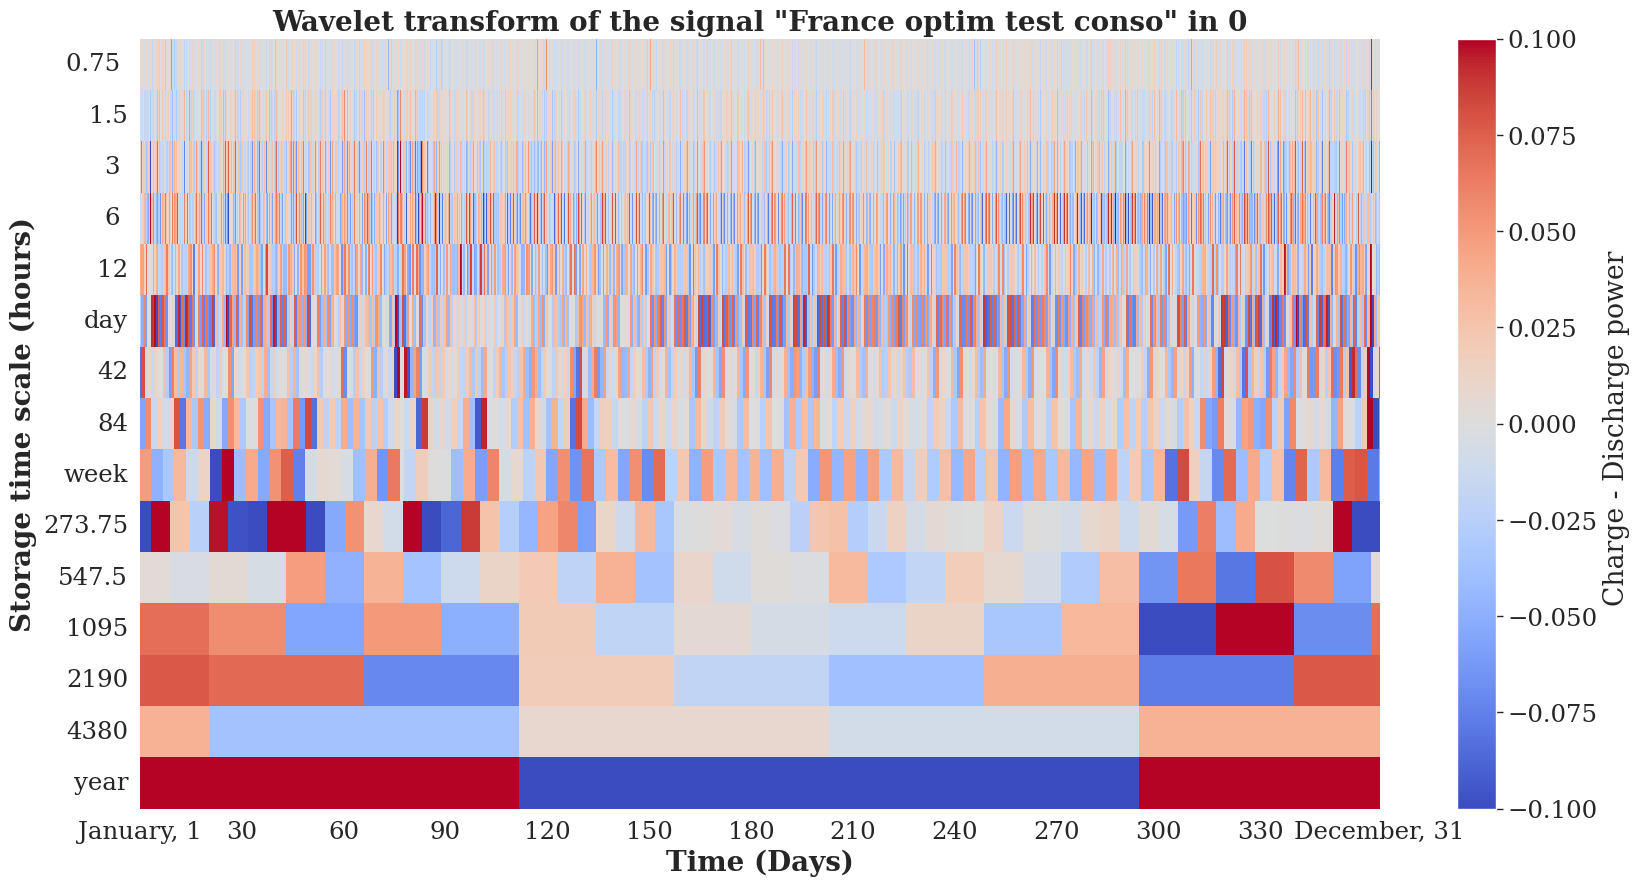

In [38]:
list_of_keys = list(per_year_betas_conso.keys())
print(list_of_keys)

# First, select the year that must be plotted
year = list_of_keys[0]
years = list_of_keys
print("Selected Year for heatmap plot:", year)
print("Total number of year:", list_of_keys)

name = f'{country_name} optim test conso' # Name printed in the heatmap title

# The directory where the matrix is saved. In this case, we are using square matric
# Replace square by sine for the sine wavelet decomposition


matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)

df = preplotprocessing(vy, vw , vd, ndpd, dpy, 
                      year, years,
                      time_scales,
                      per_year_betas_conso, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
                      matrix)

plot_betas_heatmap(df, name , year , ndpd,
                      cmin= -0.1,
                      cmax= 0.1,
                    ccenter = None)

['0']
Selected Year for heatmap plot: 0
Total number of year: ['0']


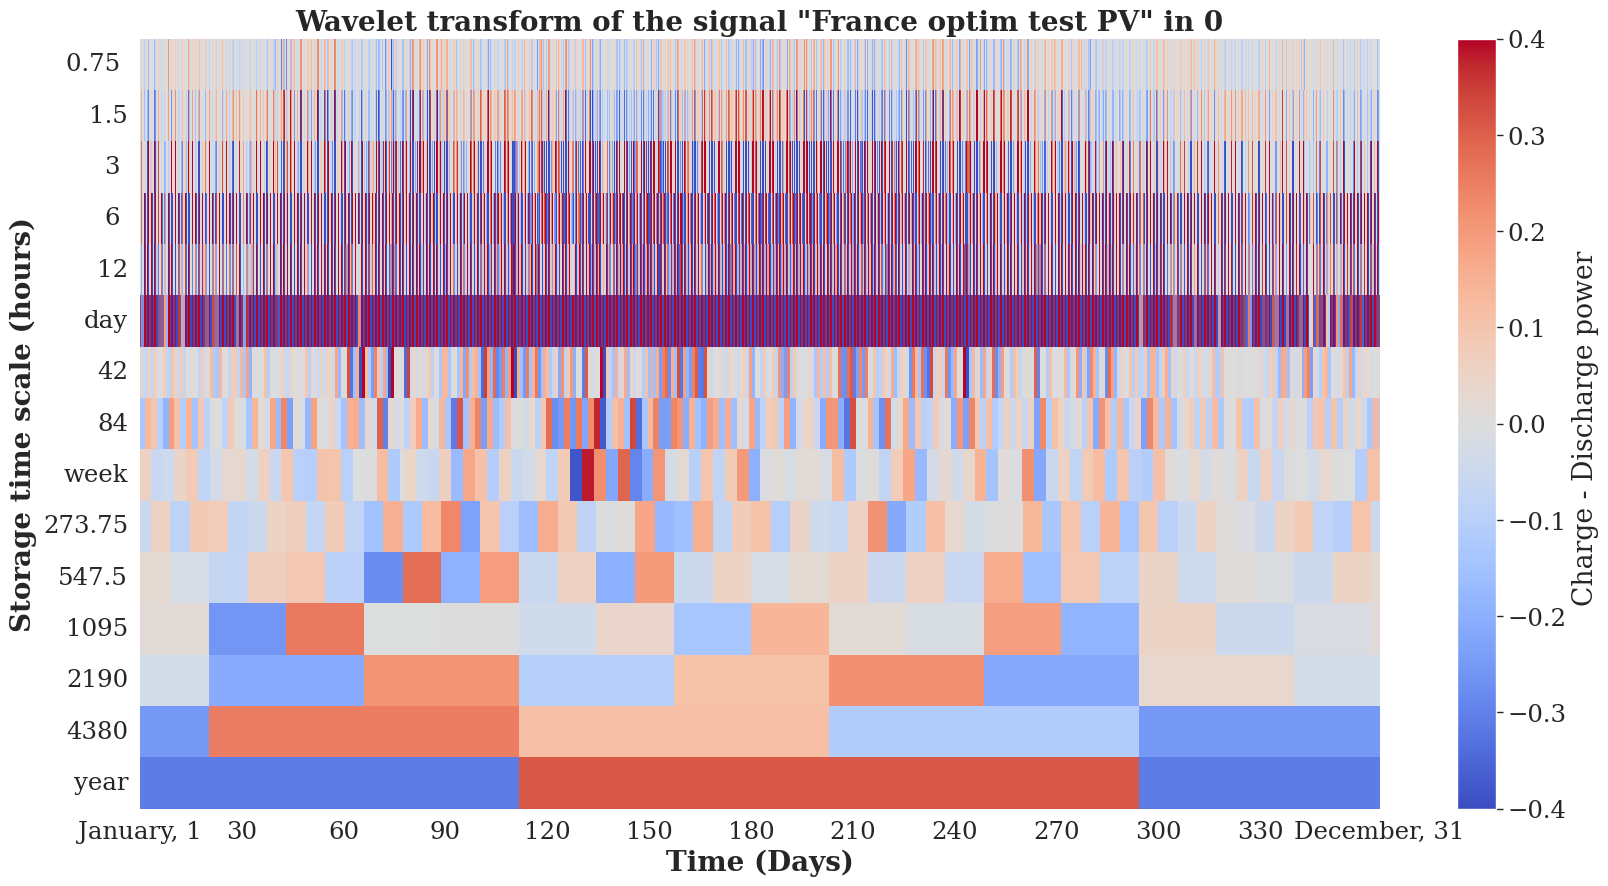

In [39]:
list_of_keys = list(per_year_betas_pv.keys())
print(list_of_keys)

# First, select the year that must be plotted
year = list_of_keys[0]
years = list_of_keys
print("Selected Year for heatmap plot:", year)
print("Total number of year:", list_of_keys)

name = f'{country_name} optim test PV' # Name printed in the heatmap title

# The directory where the matrix is saved. In this case, we are using square matric
# Replace square by sine for the sine wavelet decomposition
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)

df = preplotprocessing(vy, vw , vd, ndpd, dpy, 
                      year, years,
                      time_scales,
                      per_year_betas_pv, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
                      matrix)

plot_betas_heatmap(df, name , year , ndpd,
                      cmin= -0.4,
                      cmax= 0.4,
                    ccenter = None)

['0']
Selected Year for heatmap plot: 0
Total number of year: ['0']


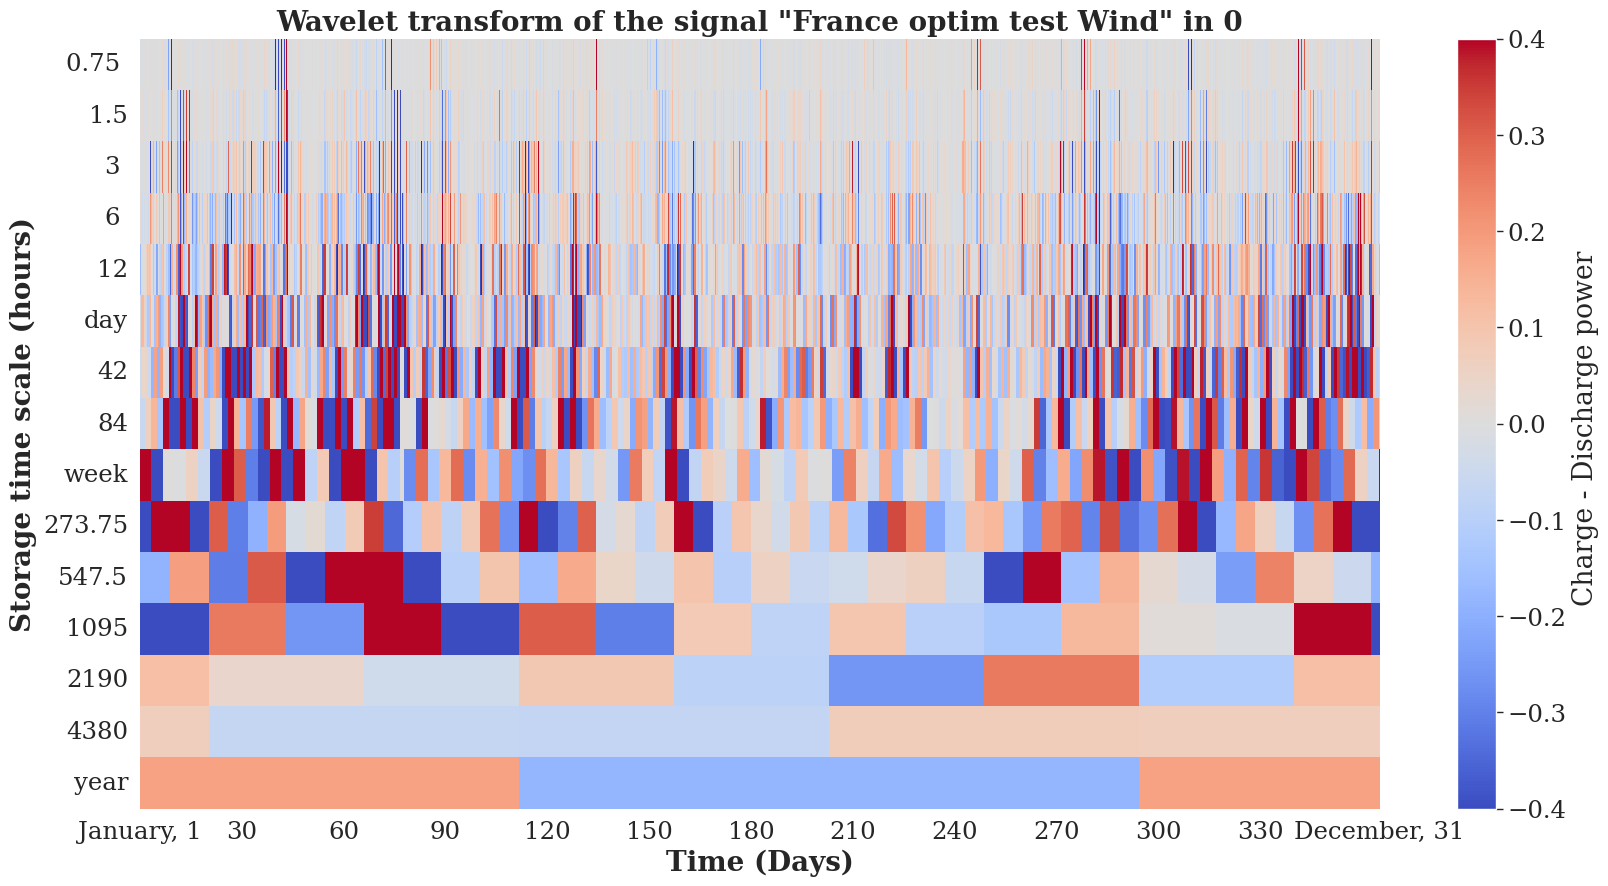

In [40]:
list_of_keys = list(per_year_betas_conso.keys())
print(list_of_keys)

# First, select the year that must be plotted
year = list_of_keys[0]
years = list_of_keys
print("Selected Year for heatmap plot:", year)
print("Total number of year:", list_of_keys)

name = f'{country_name} optim test Wind' # Name printed in the heatmap title

# The directory where the matrix is saved. In this case, we are using square matric
# Replace square by sine for the sine wavelet decomposition


matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)

df = preplotprocessing(vy, vw , vd, ndpd, dpy, 
                      year, years,
                      time_scales,
                      per_year_betas_wind, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
                      matrix)

plot_betas_heatmap(df, name , year , ndpd,
                      cmin= -0.4,
                      cmax= 0.4,
                    ccenter = None)

# Computing Energy, Power, and Nb of Cycles
<br/>

### From the coefficients betas of the wavelet decomposition, we can determine the flexibility required by the energy system

<br/>

***Satisfaction rate:*** Percentage of the time the consumption is satisfied. Examples:
* If satisfaction rate = 90%: At the day scales 0.9*365=328 days per year, the energy demand will be satisfied. We get rid of the 365-328=37 days with the highest electricity consumption
* Here the signal last 7 years. With a 90% satisfaction rate we get rid of the 37*7 extreme days over the last 7 years

In [21]:
pop = 68
load_factor = mean_load/pop # to get physically relevant values
pie_wind = 48.1
pie_pv = 30.4
share_wind = pie_wind/(pie_pv+pie_wind)
share_pv = pie_pv/(pie_pv+pie_wind)
# share_wind = pie_wind/100
# share_pv = pie_pv/100


In [22]:
mean_load

53225.021061643834

In [23]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = f'{country_name} optimized'
#conso = stacked_betas_square['Consumption']
#prod =  stacked_betas_square['PV']


pmc = [np.array(stacked_betas_conso[i]) -share_pv*np.array(stacked_betas_pv[i]) -share_wind*np.array(stacked_betas_wind[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100] # Satisfaction rate
# Percentage of the t0000000ime the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_residual = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
# plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
#          time_scales, satisfactions, scenario_name )

Calculations are made on a 1 years dataset


In [24]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = f'{country_name} no intermittent'
#conso = stacked_betas_square['Consumption']
#prod =  stacked_betas_square['PV']


pmc = stacked_betas_conso

satisfactions = [80,95,99,100] # Satisfaction rate
# Percentage of the t0000000ime the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_no = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
# plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
#          time_scales, satisfactions, scenario_name )

Calculations are made on a 1 years dataset


In [25]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = f'{country_name} 100% PV'
#conso = stacked_betas_square['Consumption']
#prod =  stacked_betas_square['PV']

pmc = [np.array(stacked_betas_conso[i]) -np.array(stacked_betas_pv[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100] # Satisfaction rate
# Percentage of the t0000000ime the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_PV = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
# plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
#          time_scales, satisfactions, scenario_name )

Calculations are made on a 1 years dataset


In [26]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = f'{country_name} 100% Wind'
#conso = stacked_betas_square['Consumption']
#prod =  stacked_betas_square['PV']


pmc=[np.array(stacked_betas_conso[i]) -np.array(stacked_betas_wind[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100] # Satisfaction rate
# Percentage of the t0000000ime the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_Wind = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
# plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
#          time_scales, satisfactions, scenario_name )

Calculations are made on a 1 years dataset


In [29]:
def plot_E_diff_countries(list_of_emax, list_of_countries, time_scales, satisfaction):

    position = satisfactions.index(satisfaction)

    # Aesthetic settings
    # Plot aesthetic settings
    sns.set()
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2})
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.set_palette("colorblind")  # set colors palettte
    plt.rc('text', usetex=False)

    markers = ['o', 'v', 's', '^', 'o', 'v', 's', '^', 'o', 'v', 's', '^']
    markers = ''.join(markers)
    mark_size = 10

    xcoords = [24, 7 * 24, 30 * 24, 365 * 24]  # verticals black line to spot the day, the week and the month

    #     labels = [None, r'10 \%', None, None, r'90 \%',None, None, None, r'100 \%']
    labels = list_of_countries

    # ----- Figure settings

    # plt.rc('text', usetex=True)  # To get Latex style in the figures
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=25)
    plt.rc('lines', linewidth=3)

    ##---- create figure ----

    fwidth = 12.  # total width of the figure in inches
    fheight = 8.  # total height of the figure in inches

    fig = plt.figure(figsize=(fwidth, fheight))

    # ---- define margins -> size in inches / figure dimension ----

    left_margin = 0.95 / fwidth
    right_margin = 0.2 / fwidth
    bottom_margin = 0.5 / fheight
    top_margin = 0.25 / fheight

    #     #---- create axes ----

    #     # dimensions are calculated relative to the figure size

    x = left_margin  # horiz. position of bottom-left corner
    y = bottom_margin  # vert. position of bottom-left corner
    w = 1 - (left_margin + right_margin)  # width of axes
    h = 1 - (bottom_margin + top_margin)  # height of axes

    ax = fig.add_axes([x, y, w, h])

    #     #---- Define the Ylabel position ----

    # Location are defined in dimension relative to the figure size

    xloc = 0.25 / fwidth
    yloc = y + h / 2.

    plt.close('all')
    ##
    
    ##
    # Energy
    plt.figure(figsize=(fwidth, fheight))
    plt.subplot()
    plt.yscale('log')
    plt.ylabel('Energy (MWh/million hab.)')
    plt.xlabel("cycle length (h)")
    plt.xscale('log')
    plt.xticks([0.75, 3, 10, 24, 168, 720, 8760], ['0.75', '3', '10', 'day', 'week', 'month', 'year'])

    plt.grid(True, which="both")
    for emax in list_of_emax:
        lines = plt.plot(time_scales, emax[:,position])
        
        for i in range(len(lines)):
           lines[i].set_visible(labels[i] is not None)
           lines[i].set_marker(markers[i])
           lines[i].set_markersize(mark_size)
    for xc in xcoords:
        plt.axvline(x=xc, linewidth=1.2, color='black', linestyle='--')

    ax.set_ylabel('yLabel', fontsize=16, verticalalignment='top',
                  horizontalalignment='center')
    ax.yaxis.set_label_coords(xloc, yloc, transform=fig.transFigure)
    plt.tight_layout()
    plt.legend(labels)
    # plt.legend([lines[i] for i, lab in enumerate(labels) if lab is not None],
    #           [labels[i] for i, lab in enumerate(labels) if lab is not None], loc='upper left')

    plt.title(f'{country_name}')
    #     plt.savefig(save_directory+data_name +'_energy' +'.'+ extension,  dpi=600, bbox_inches = 'tight')

    
    plt.show()


    return

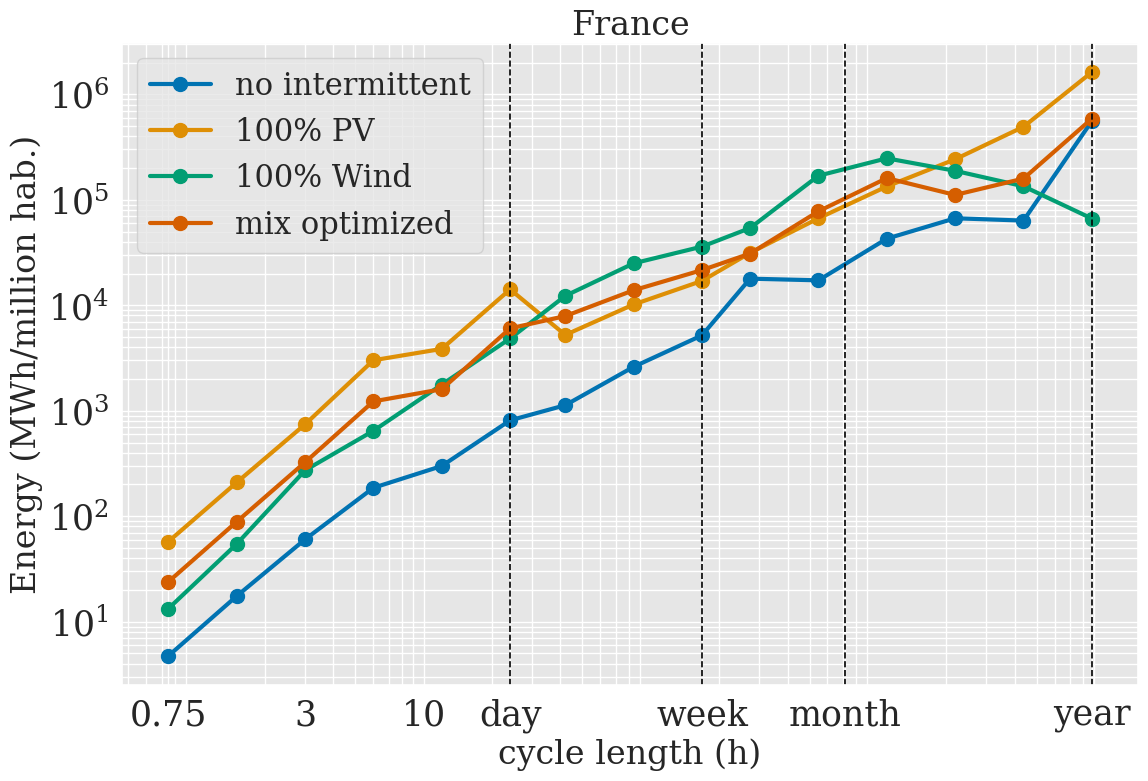

In [30]:
list_of_emax = np.array([results_no['emax'], results_PV['emax'], results_Wind['emax'], results_residual['emax']])
satisfactions = [80,95,99,100]
plot_E_diff_countries(list_of_emax, ['no intermittent', f'100% PV',f'100% Wind', f'mix optimized'], time_scales, 95)

# Somme des matrices de betas

# Essai sur une année

In [82]:
def calc_e_needed(beta, satisfaction, time_scale, load_factor): #pour une time scale et une satisfaction
    '''
    Calculate Energy, Power, nb of cycles from input betas
    Returns E, P, N, Usage factor for diferent satisfaction rates
    - load_factor : average power, the mean energy consumption
    :param shape:
    '''
    Nyears = 1

    # print('Calculations are made on a '+   str(Nyears) + ' years dataset')
    #Indices : length, satisfaction
    # pmax = np.zeros((len(time_scales), len(satisfactions))) # Power
    # emax = np.zeros((len(time_scales), len(satisfactions))) # Energy
    # n =    np.zeros((len(time_scales), len(satisfactions))) # Number of cycles
    # uf =   np.zeros((len(time_scales), len(satisfactions))) # Usage factor
    # serv = np.zeros((len(time_scales), len(satisfactions))) # Service

    veclength = time_scale
    betac= beta
    betac_array = np.array(beta)
    isatis = np.ceil(np.asarray(satisfaction) * len(betac) / 100.) - 1.
    isatis = isatis.astype(int)
    dech_satis = np.zeros(1)
    n_satis = np.zeros(1)
    # print(isatis)
    dech = np.sort(np.abs(betac_array))
    # print(dech)
    dech_satis[0] = dech[isatis[0]]
    n_satis[0] = sum(np.minimum(dech, dech_satis[0])) / dech_satis[0] / Nyears

    pmax = dech_satis * load_factor
    
    emax= pmax * veclength / 2.
    
    return emax

In [100]:
def calc_flex_annual(x, conso, pv, wind, satisfaction, time_scale, load_factor):
    # pmc = conso-beta*pv-alpha*wind
    alpha, beta = x
    pmc=[alpha*np.array(wind[-1]) +beta*np.array(pv[-1]) - np.array(conso[-1])]
    results = calc_e_needed(pmc, satisfaction, time_scale, load_factor)
    # print(results)
    # value = results['emax'][-1][0]
    # print(value)
    return results[0].squeeze()

In [101]:
time_scale =8760. # cycles length, in hours
satisfaction = [100] # Satisfaction rate
calc_e_needed(stacked_betas_conso[-1], satisfaction, time_scale, load_factor )

array([3.61497498e+10])

In [102]:
calc_flex_annual([0.2,0.5], stacked_betas_conso, stacked_betas_PV, stacked_betas_Wind, satisfaction, time_scale, load_factor)

C:\Users\JD278300\AppData\Local\Temp\ipykernel_26808\215497960.py:28: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\JD278300\AppData\Local\Temp\ipykernel_26808\215497960.py:29: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



10845877745.93274

In [99]:
from scipy.optimize import minimize
x_initial = [0.1,0.5]
time_scales = 8760. # cycles length, in hours
satisfactions = [100] # Satisfaction rate
resultat=minimize(calc_flex_annual, x_initial, args=(stacked_betas_conso, stacked_betas_PV, stacked_betas_Wind, satisfactions, time_scales, load_factor))
print("Part d'éolien:", resultat.x[0])
print("Part de solaire:", resultat.x[1])
print("Valeur de la fonction à ce minimum:", resultat.fun)

Part d'éolien: -0.6999907673856743
Part de solaire: -0.3001071595810719
Valeur de la fonction à ce minimum: 182.31282921988168


C:\Users\JD278300\AppData\Local\Temp\ipykernel_26808\215497960.py:28: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\JD278300\AppData\Local\Temp\ipykernel_26808\215497960.py:29: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\JD278300\AppData\Local\Temp\ipykernel_26808\215497960.py:28: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\JD278300\AppData\Local\Temp\ipykernel_26808\215497960.py:29: DeprecationWarning:

Conversion of an array with nd

In [40]:
calc_flex_annual([0.3, 0.2], stacked_betas_conso[-1], stacked_betas_PV[-1], stacked_betas_Wind[-1], satisfactions, time_scales, dpy, load_factor)

TypeError: object of type 'numpy.float64' has no len()

In [36]:
from scipy.optimize import minimize
x_initial = [0.2,0.5]
time_scales = [8760.] # cycles length, in hours
satisfactions = [100] # Satisfaction rate
resultat=minimize(calc_flex_annual, x_initial, args=(stacked_betas_conso, stacked_betas_PV, stacked_betas_Wind, satisfactions, time_scales, dpy, load_factor))
print("Part d'éolien:", resultat.x[0])
print("Part de solaire:", resultat.x[1])
print("Valeur de la fonction à ce minimum:", resultat.fun)

Calculations are made on a 11680 years dataset
44303319.033448346
Calculations are made on a 11680 years dataset
44303319.99087887
Calculations are made on a 11680 years dataset
44303319.70704296
Calculations are made on a 11680 years dataset
84323630.85965961
Calculations are made on a 11680 years dataset
84323628.466196
Calculations are made on a 11680 years dataset
84323631.06959102
Calculations are made on a 11680 years dataset
25090700.982486047
Calculations are made on a 11680 years dataset
25090701.002445173
Calculations are made on a 11680 years dataset
25090702.078481846
Calculations are made on a 11680 years dataset
25774350.224028427
Calculations are made on a 11680 years dataset
25774347.830564808
Calculations are made on a 11680 years dataset
25774350.433959827
Calculations are made on a 11680 years dataset
15671896.934876325
Calculations are made on a 11680 years dataset
15671896.176054446
Calculations are made on a 11680 years dataset
15671896.974552646
Calculations are 

Calculations are made on a 1 years dataset


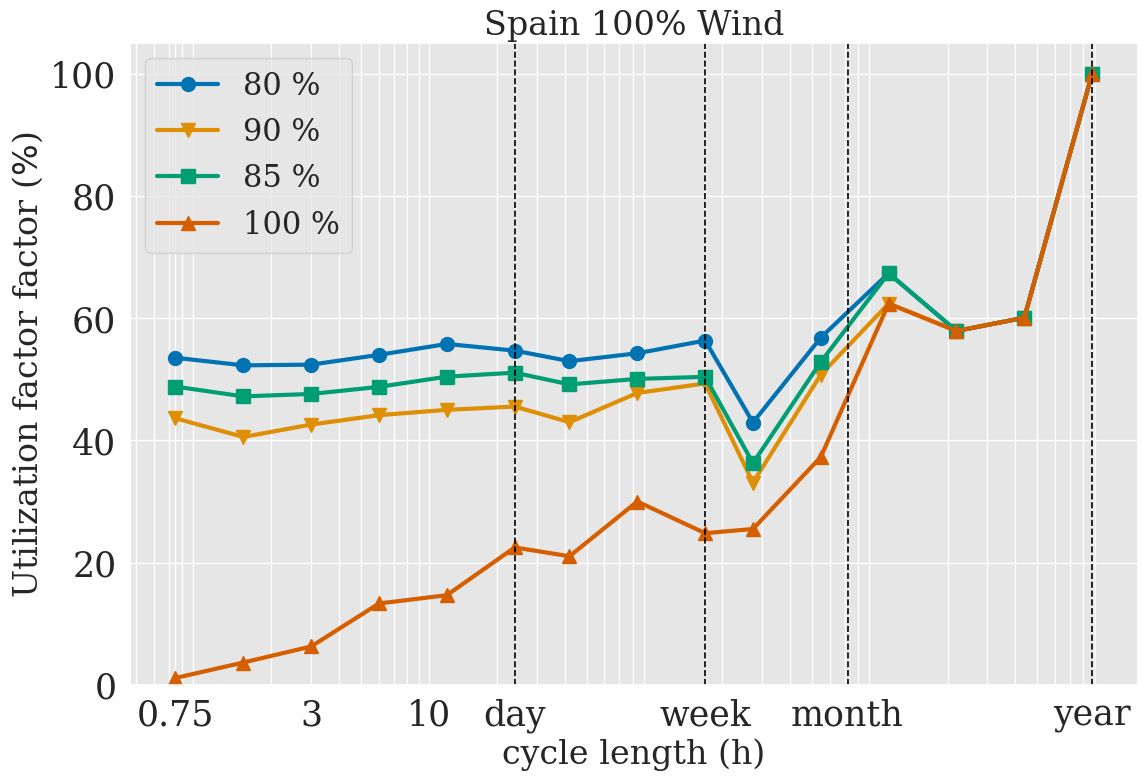

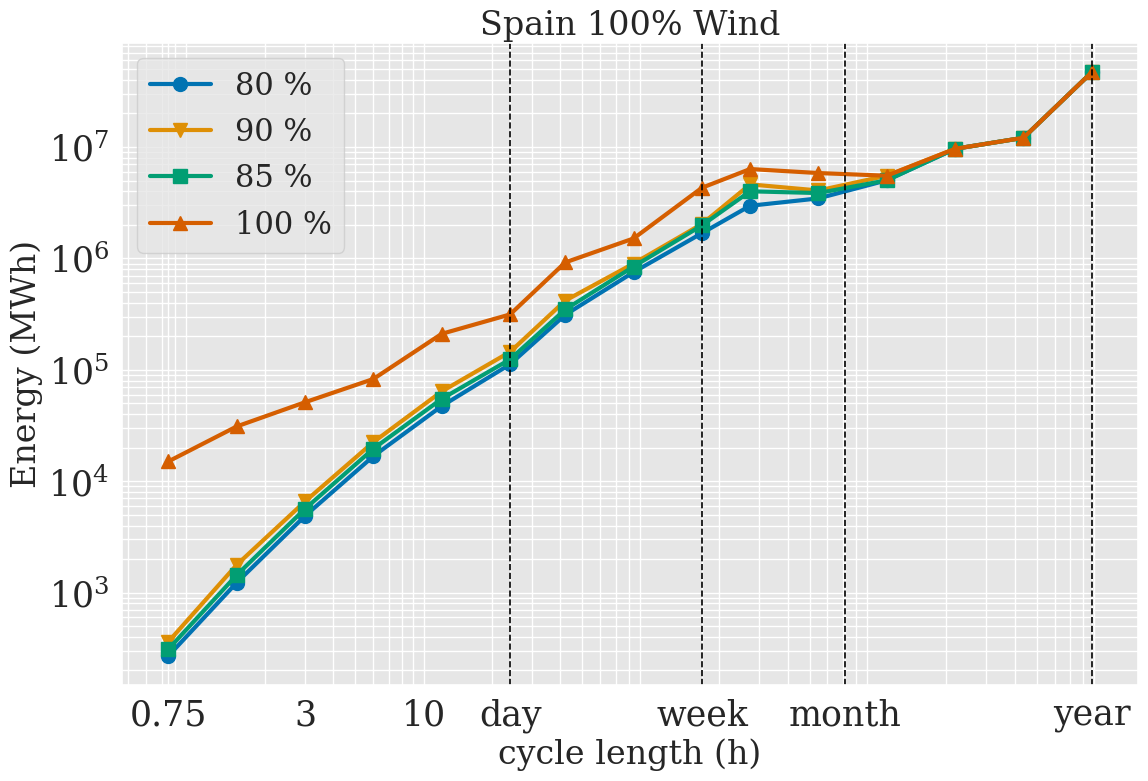

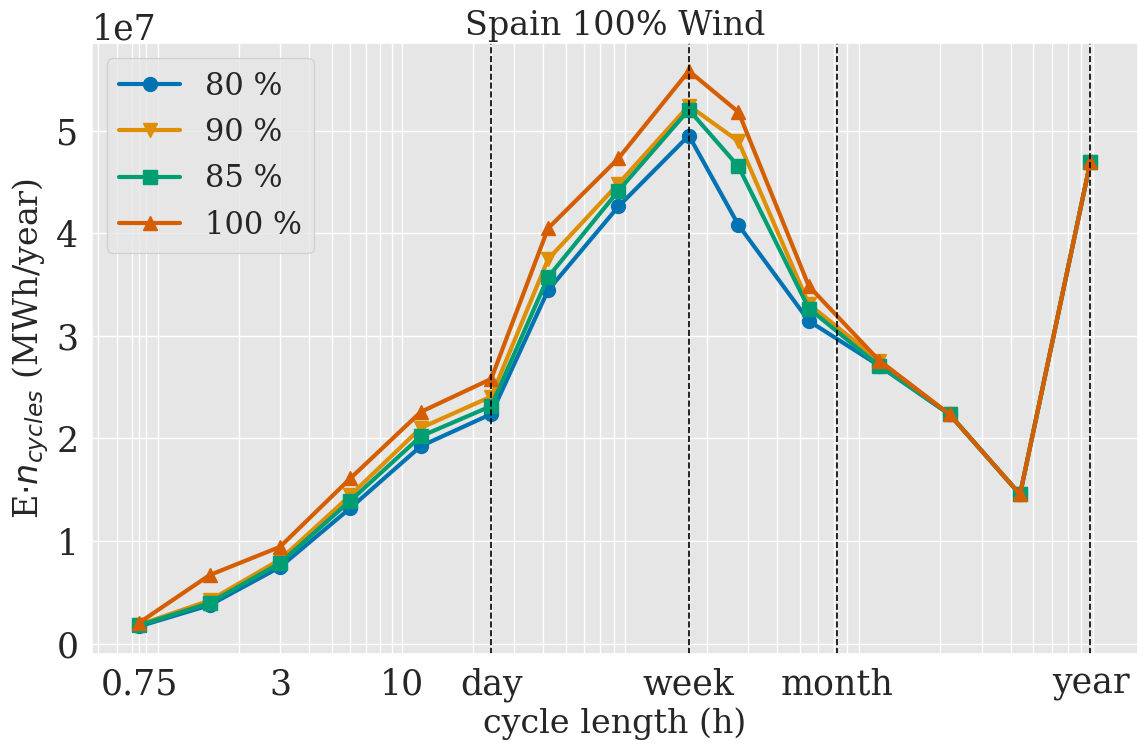

: 

In [40]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = 'Spain 100% Wind'
conso = stacked_betas_conso
prod =  stacked_betas_Wind

load_factor=54000

pmc =  [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,90,85,100] # Satisfaction rate
# Percentage of the t0000000ime the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

Calculations are made on a 1 years dataset


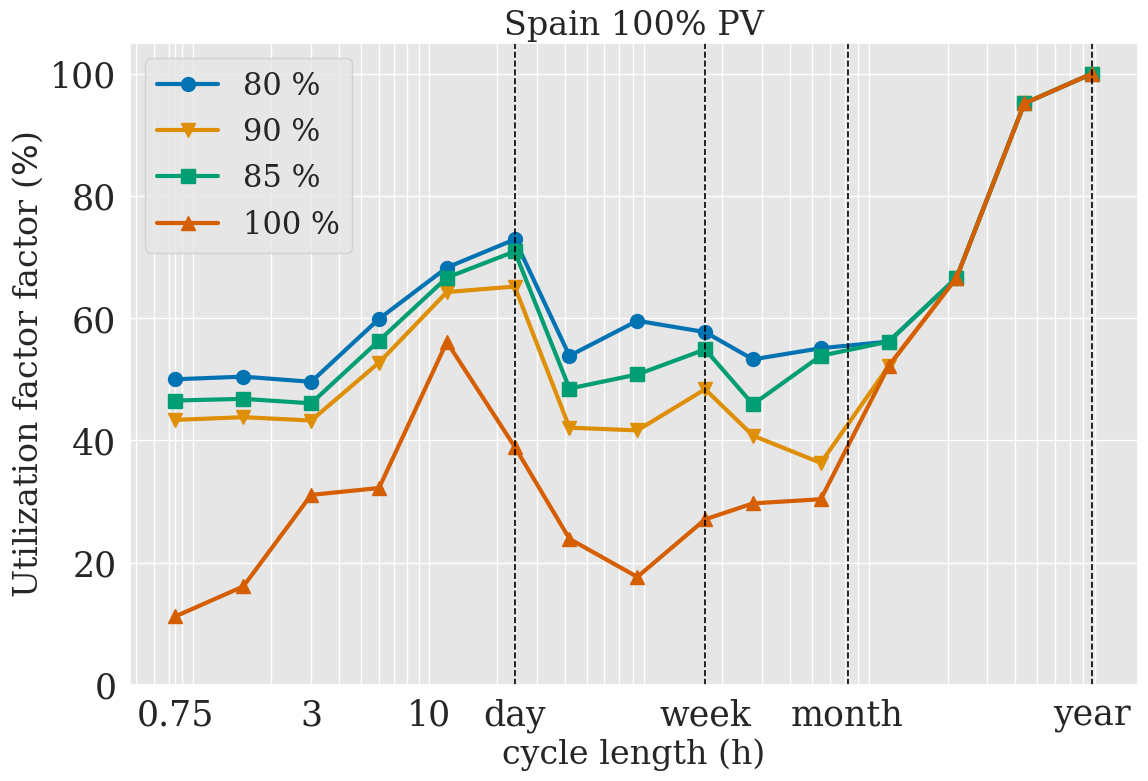

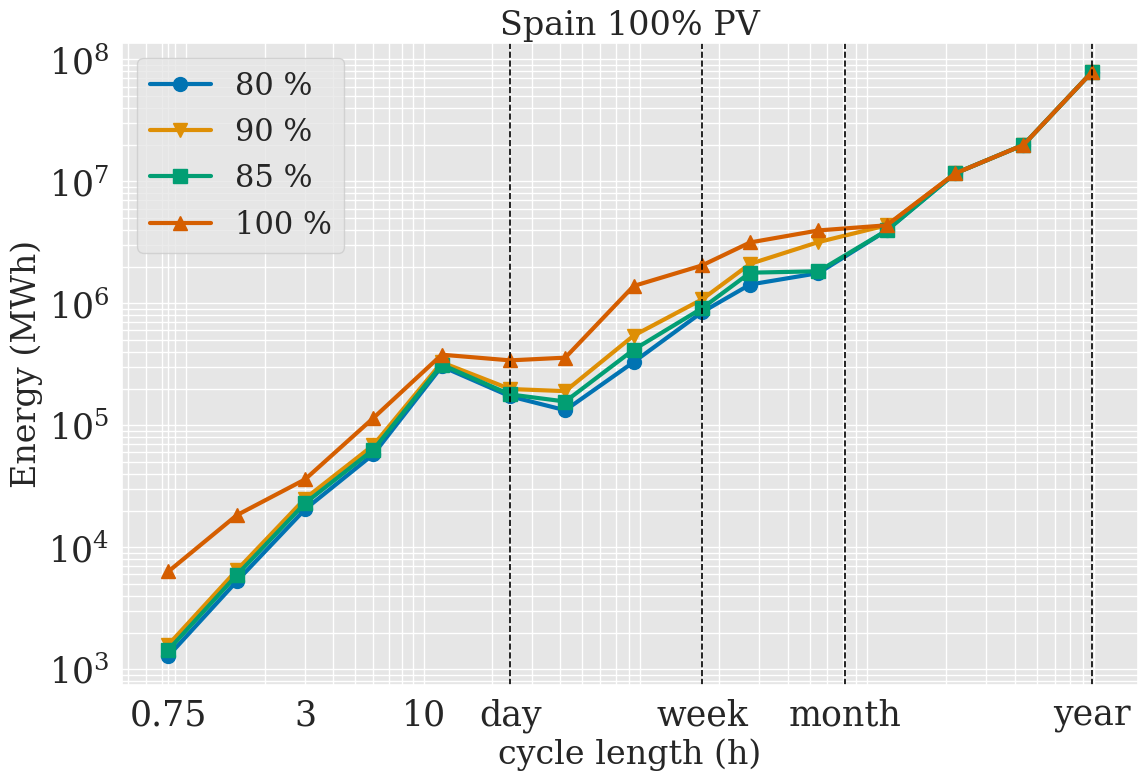

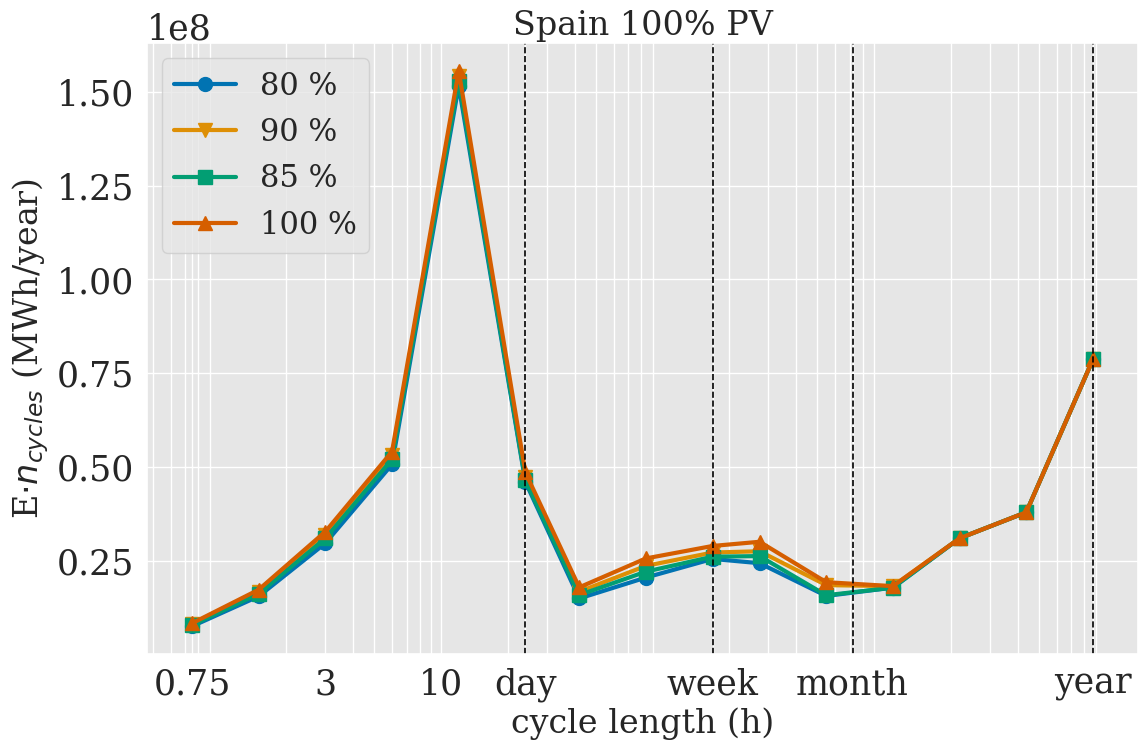

In [39]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = 'Spain 100% PV'
conso = stacked_betas_conso
prod =  stacked_betas_PV

load_factor=54000

pmc =  [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,90,85,100] # Satisfaction rate
# Percentage of the t0000000ime the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

# Reconstructing and filtering signals

In [ ]:
#
# Importing Matrix for the reconstruction
year = '2013'

path_matrix = "saved_matrix\\square_shape\\"
# path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# #
reconstruct(time_scales, [12, 24],
                matrix,saved_sheets_square['PV'][year], "2013 PV signal filtered with 12h and 24h square wavelets",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, [24],
                matrix,saved_sheets_square['PV'][year], "2013 PV signal filtered with 24h square wavelets",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_square['PV'][year], "Reconstructed PV signal",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

# To translate or not translate ?
<br/>
<center> <bold> Results comparison with translations and without translations </bold></center>

In [ ]:
# -----------------------------------------------
# ------ Create translations full of zeros -----
# -----------------------------------------------
zero_trans = []
Nyears = int(len(stacked_input_data['Consumption'])/(ndpd*dpy) )
for i in range(Nyears):
    zero_trans.append([0,0,0])
    
# ----------------------------------------------------
# ------ Decomposition with without translations -----
# ----------------------------------------------------

path_matrix = "saved_matrix\\square_shape\\no_trans\\"
beta_path = "betas\\square_shape_no_trans\\"

stacked_betas_square_no_trans, saved_sheets_square_no_trans = compute_wavelet_coefficient_betas(time_series, stacked_input_data,
                 vy, vw, vd, dpy, ndpd, years,
                 zero_trans,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True)

pkl.dump([stacked_betas_square_no_trans, saved_sheets_square_no_trans], open('betas_saved_square_no_trans' + '.p', "wb"))

# [stacked_betas_square_no_trans, saved_sheets_square_no_trans] = pkl.load(open('betas_saved_square_no_trans' + '.p', "rb"))

In [ ]:
# --------------------------------------
# -- Same plots without translations ---
# --------------------------------------
scenario_name = 'PV, square wavelet decomposition without translation'
conso = stacked_betas_square_no_trans['Consumption']
prod =  stacked_betas_square_no_trans['PV']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_PV_no_trans = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results_square_PV_no_trans['emax'], results_square_PV_no_trans['pmax'], results_square_PV_no_trans['n'], results_square_PV_no_trans['uf'], results_square_PV_no_trans['serv'],
         time_scales, satisfactions, scenario_name )

# Sine and square shape wavelets
<br/>
Wavelets can take various shapes. We used here both sine and square shape. Here is and example of a sine shape decomposition

In [ ]:
# -------- Import translations -----
trans_file = 'trans_sine_12_18'

trans_sine = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consommation',
                   ndpd, dpy, 
                   'sine', do_calc=False)
# ------Perform wavelet decomposition ----

beta_path = "betas\\sine_shape\\"

path_matrix = "saved_matrix\\sine_shape\\"

stacked_betas_sine, saved_sheets_sine = compute_wavelet_coefficient_betas(time_series, stacked_input_data,
                 vy,vw,vd,dpy, ndpd, years,
                 trans_sine,
                 path_matrix,
                 beta_path, wl_shape ='sine', imp_matrix = True)

# ----- Plot 100% PV scenario ---

scenario_name = 'PV, sine wavelet decomposition'
sine_conso = stacked_betas_sine['Consumption']
sine_prod =  stacked_betas_sine['PV']

sine_pmc = [np.array(sine_prod[i]) - np.array(sine_conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_sine = calc_epn(sine_pmc, satisfactions, time_scales, dpy, load_factor, shape = 'sine')

In [ ]:
plot_EPN(results_sine['emax'], results_sine['pmax'], results_sine['n'], results_sine['uf'], results_sine['serv'],
         time_scales, satisfactions, scenario_name )

In [ ]:
# -------- Reconstruct signal -----

year = '2013'
path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# #
reconstruct(time_scales, [24],
                matrix,saved_sheets_sine['PV'][year], "Signal PV 2013 with 24 hours sine wavelets",
                xmin=0, xmax=15,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_sine['PV'][year], "2013 PV signal reconsruction",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)